# Data Wrangling/Munging

Before commencing our data exploration journey, I want you to read [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) by Pedro Domingos.

In [1]:
!wget https://raw.githubusercontent.com/tezzytezzy/caravan-insurance-policy/master/ticdata2000.txt
!wget https://raw.githubusercontent.com/tezzytezzy/caravan-insurance-policy/master/dictionary.txt
!wget https://raw.githubusercontent.com/tezzytezzy/caravan-insurance-policy/master/ticeval2000.txt
!wget https://raw.githubusercontent.com/tezzytezzy/caravan-insurance-policy/master/tictgts2000.txt

--2020-07-06 05:41:32--  https://raw.githubusercontent.com/tezzytezzy/caravan-insurance-policy/master/ticdata2000.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1011973 (988K) [text/plain]
Saving to: ‘ticdata2000.txt’

ticdata2000.txt     100%[===================>] 988.25K  --.-KB/s    in 0.05s   

2020-07-06 05:41:32 (20.2 MB/s) - ‘ticdata2000.txt’ saved [1011973/1011973]

--2020-07-06 05:41:35--  https://raw.githubusercontent.com/tezzytezzy/caravan-insurance-policy/master/dictionary.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [2]:
import pandas as pd
import numpy as np
from google.colab import files

# header=0 doens't work, header=None simply inserts intergers as column names
df_raw = pd.read_csv(r"./ticdata2000.txt", sep='\t', header=None, low_memory=False) # Training set

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
### DEPRECATED BY THE FOLLOWING CELL ###

# def get_item_description(start_row, end_row, from_nth_field_onward):
#     """
#     RETURN: A list of extracted item names
#     start_row: Starting row number of dictionary.txt
#     end_row: Ending row number of dictionary.txt
#     from_nth_field_onward: Take out a n-th field, delimited by space, and further to the right
#     """
    
#     # Thought of returning a ndarray but a "DeprecationWarning: 
#     #  "using a non-integer array as obj in delete will result in an error in the future"
#     import subprocess
    
#     unix_shell_command = 'awk \'NR>={0}&&NR<={1}\' "./dictionary.txt" | cut -d\  -f{2}- '.format(start_row, end_row, from_nth_field_onward)
    
#     headers = subprocess.check_output(unix_shell_command, shell=True)
    
#     #headers = subprocess.check_output('awk \'NR>=' + str(start_row) + '&&NR<=' + str(end_row) + '\' "./dictionary.txt" | cut -d\  -f3- ', shell=True)
#     #headers = subprocess.check_output('awk \'NR>=4&&NR<=89\' "./dictionary.txt" | cut -d\  -f3- ', shell=True)
#     # awk \'NR>=4&&NR<=89\' "./dictionary.txt" => take lines between 4 and 89, both incluive
#     #  (NOTE: escape character of "\" before ')
#     # cut -d\  -f3- => delimiter of a single space with escape character of "\" and
#     #  taking in the 3rd field onwards until end of the line
#     # This returns byte string e.g., b'Customer Subtype see L0\nNumber of...'

#     # Alternative to 'subprocess.check_output' is as follows:
#     # import os
#     # os.system("command")

#     header_list = "".join(map(chr, headers)).split('\n')
#     # "".join(map(chr, headers)) => convert bytes to a string
#     # .split('\n') => put the produced string into a list delimited by a line feed

#     header_list.pop()
#     # Unfortuantely this leaves a zero-string list item at the very end i.e., (''), so take it out

#     return header_list

In [5]:
def collect_data(keyword, first_item_number, from_nth_field):
    """
    RETURN
    A list of items in data file
    
    INPUT
    keyword: Below which section to start collecting data
    first_item_number: Either 0 or 1, by which a first item is numbered
    from_nth_field: The number on and which field to the end of line to extract, delimited by a single space ' '
    """

    path_and_file_name_of_dictionary = "./dictionary.txt" # In relation to this ipynb file
    item_list = []
    
    section_found = False
    item_found = False
    end_of_info = False

    # Without "encoding="ISO-8859-1", non-printbale character spits "UnicodeDecodeError: 'utf-8' codec can't decode..."
    with open (path_and_file_name_of_dictionary, 'rt', encoding="ISO-8859-1") as myfile:
        for a_line in myfile:
            if (not end_of_info):
                if (not section_found) and (a_line[:len(keyword)] == keyword):
                    section_found = True
                elif section_found and (a_line[0]== str(first_item_number) or item_found):
                    if a_line == '\n':
                        end_of_info = True
                    else:
                        item_name = ''
                        field_list = a_line.split()

                        for idx in range(from_nth_field - 1, len(field_list)):
                            item_name = item_name + ' ' + field_list[idx]

                        item_list.append(item_name[1:len(item_name)])
                        item_found = True
            else:
                return item_list
    return item_list # When reaching end of file, this line gets executed for 'L4'

In [6]:
def fetch_list_item(nd_array, keyword, from_nth_index = 0):
    """
    RETURN
    A tuple of matched item AND index number 
    
    INPUT
    keyword: By which to search column name
    from_nth_index: Perform "exact" search to see if string match FROM the end of string ONLY
    """
    
    for index, item in enumerate(nd_array):
        if index >= from_nth_index:
            if item[-len(keyword):] == keyword:
                return index, item
    return None

In [7]:
def remove_duplicate(df_series, dictionary, offset):
    """
    RETURN
    A list without a duplicate
    
    INPUT
    df_series: A DataFrame Series, i.e., one-column DataFrame
    dictionary: A list of items in the look-up dictionary
    offset: Either 0 or 1, by which to offset raw data numbers as the dicionary is always 0-based
    """
    
    # Create a ndarray from a DataFrame column
    nd_array_data = df_series.to_numpy()
    
    # DEBUG np.savetxt(r"./test_start.txt", nd_array_data)
    
    duplicate_items = []
    
    for index, item in enumerate(dictionary):
        if dictionary.count(item) > 1:
            res =  fetch_list_item(dictionary, item, index+1)
            if res is not None:
            # Locate the index of the OTHER duplicate, to be kept and aligned, from the beginning of the list
                duplicate_num, _ = res

                duplicate_items.append([index, duplicate_num])
    
    # Finally take out the duplicates        
    for dup in duplicate_items:
        dictionary.pop(dup[0]) 
        
        # The subsequent items of the found duplicate must be pushed forward by subtracting 1, to have it aligned with dictionary.txt
        nd_array_data = np.where(nd_array_data>dup[0], nd_array_data - 1, nd_array_data)
        
        # Now replace the duplicate index with the OTHER index of its identical entry
        nd_array_data[np.where(nd_array_data==dup[0])] = dup[1]

    # Adjust raw data numbers where its corresponding column/field in the dectionary list has 1-based order
    nd_array_data = nd_array_data - offset
    
    return dictionary, nd_array_data

In [8]:
def change_column_type_from_int64_to_category():
    """
    Format DataFrame columns by replacing 'pure' indices in dictionary.txt with corresponding names
    """
    dictionary_label_prefix = 'L'
    
    data_tables = [[0, 1, 2], 
                     [1, 1, 2], 
                     [2, 1, 2], 
                     [3, 0, 2], 
                     [4, 0, 2]]
    # 1st element: A number - prefixed with 'L' - whose table in the dictionary.txt describes further e.g., L0, L1, and L2
    # 2nd element: N-based index in the dictionary.txt. Where it's 1 
    #              we subtract 1 from the original data to make it zero(0)-based, so as to suit indexes of category type
    # 3rd element: The number of n-th field in each line to be taken    

    def remove_duplicate_and_assign_new_values(df, item):
        label_list, new_values = remove_duplicate(df[item], 
                                                collect_data(dictionary_label_prefix + str(i[0]), i[1], i[2]),
                                                i[1])
            
        df[item] = new_values
    
    for i in data_tables:
        res = fetch_list_item(list_of_column_names,
                              dictionary_label_prefix + str(i[0]),
                              0)
        if res is not None:
            index, item = res
            
            remove_duplicate_and_assign_new_values(df_raw, item)
            remove_duplicate_and_assign_new_values(X_test, item)
            #label_list, new_values = remove_duplicate(df_raw[item], 
            #                                                    collect_data(dictionary_label_prefix + str(i[0]), i[1], i[2]),
            #                                                    i[1])
            
            
            #df_raw[item] = new_values
            
            ###
            # The following fails to convert string to categorical variables for some reason!
            ###
            #df_raw[item] = df_raw[item].astype('category').cat.as_ordered()
            #
            #df_raw[item] = pd.CategoricalIndex(df_raw[item].map(dict(enumerate(label_list))),
            #                                     ordered=True, 
            #                                     categories=label_list)
            

In [9]:
column_names = [["DATA DICTIONARY", 1, 3]]
list_of_column_names = collect_data(str(column_names[0][0]), column_names[0][1], column_names[0][2])

df_raw.columns = list_of_column_names

feature_labels = list_of_column_names[:-1]
# Take out the last column 'Number of mobile home policies 0 - 1' as NOT included
X_test = pd.read_csv("./ticeval2000.txt", sep='\t', header=None, low_memory=False) # Test set
X_test.columns = feature_labels

In [10]:
df_raw.head()

,Customer Subtype see L0,Number of houses 1  10,Avg size household 1  6,Avg age see L1,Customer main type see L2,Roman catholic see L3,Protestant ...,Other religion,No religion,Married,Living together,Other relation,Singles,Household without children,Household with children,High level education,Medium level education,Lower level education,High status,Entrepreneur,Farmer,Middle management,Skilled labourers,Unskilled labourers,Social class A,Social class B1,Social class B2,Social class C,Social class D,Rented house,Home owners,1 car,2 cars,No car,National Health Service,Private health insurance,Income < 30.000,Income 30-45.000,Income 45-75.000,Income 75-122.000,...,Contribution car policies,Contribution delivery van policies,Contribution motorcycle/scooter policies,Contribution lorry policies,Contribution trailer policies,Contribution tractor policies,Contribution agricultural machines policies,Contribution moped policies,Contribution life insurances,Contribution private accident insurance policies,Contribution family accidents insurance policies,Contribution disability insurance policies,Contribution fire policies,Contribution surfboard policies,Contribution boat policies,Contribution bicycle policies,Contribution property insurance policies,Contribution social security insurance policies,Number of private third party insurance 1 - 12,Number of third party insurance (firms) ...,Number of third party insurane (agriculture),Number of car policies,Number of delivery van policies,Number of motorcycle/scooter policies,Number of lorry policies,Number of trailer policies,Number of tractor policies,Number of agricultural machines policies,Number of moped policies,Number of life insurances,Number of private accident insurance policies,Number of family accidents insurance policies,Number of disability insurance policies,Number of fire policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies,Number of mobile home policies 0 - 1
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [11]:
change_column_type_from_int64_to_category()

In [12]:
df_raw.head()

,Customer Subtype see L0,Number of houses 1  10,Avg size household 1  6,Avg age see L1,Customer main type see L2,Roman catholic see L3,Protestant ...,Other religion,No religion,Married,Living together,Other relation,Singles,Household without children,Household with children,High level education,Medium level education,Lower level education,High status,Entrepreneur,Farmer,Middle management,Skilled labourers,Unskilled labourers,Social class A,Social class B1,Social class B2,Social class C,Social class D,Rented house,Home owners,1 car,2 cars,No car,National Health Service,Private health insurance,Income < 30.000,Income 30-45.000,Income 45-75.000,Income 75-122.000,...,Contribution car policies,Contribution delivery van policies,Contribution motorcycle/scooter policies,Contribution lorry policies,Contribution trailer policies,Contribution tractor policies,Contribution agricultural machines policies,Contribution moped policies,Contribution life insurances,Contribution private accident insurance policies,Contribution family accidents insurance policies,Contribution disability insurance policies,Contribution fire policies,Contribution surfboard policies,Contribution boat policies,Contribution bicycle policies,Contribution property insurance policies,Contribution social security insurance policies,Number of private third party insurance 1 - 12,Number of third party insurance (firms) ...,Number of third party insurane (agriculture),Number of car policies,Number of delivery van policies,Number of motorcycle/scooter policies,Number of lorry policies,Number of trailer policies,Number of tractor policies,Number of agricultural machines policies,Number of moped policies,Number of life insurances,Number of private accident insurance policies,Number of family accidents insurance policies,Number of disability insurance policies,Number of fire policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies,Number of mobile home policies 0 - 1
0,31,1,3,1,7,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,35,1,2,1,7,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,35,1,2,1,7,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,7,1,3,2,2,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,38,1,4,1,9,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_raw.to_feather('formatted_raw_data')

# Data Exploring

In [ ]:
df_raw = pd.read_feather('formatted_raw_data')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Good benchmark to extract validation set out of training set is 20% according to Fast.ai's Jeremy Howard. Thus, train_size is set to **0.8** below. Also take a look at this [How (and Why) to Create a Good Validation Set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

The sample is NOT a timeseries data and thus cross-validation can be a good candidate as well as out-of-bag hyperparameter in Random Forest.

In [ ]:
# Separate into 2 DataFrames:
#  1. Target/Dependent value (Attribute 86, "CARAVAN:Number of mobile home policies") and 
#  2. Features

# Tuple is zero-based, but columns is one-based
col_idx = df_raw.shape[1]-1

df_target = df_raw.iloc[:, col_idx]
df_features = df_raw.drop(df_raw.columns[col_idx], axis='columns')

# Use train_test_split to create train and validation set instead of test set, which we already have
# Random seed is of course '42' due to 'The Hitchhiker's Guide to the Galaxy'!
X_train, X_valid, y_train, y_valid = train_test_split(df_features, df_target, train_size=0.8, random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((4657, 85), (1165, 85), (4657,), (1165,), (4000, 85))

Let's train a model!

In [ ]:
clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
# Take Python 3.7 default value n_estimators = 100

clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9931286235774104

R^2, a fit measure, is pretty good.

In [ ]:
clf.predict_proba(X_valid)

array([[0.986     , 0.014     ],
       [0.99      , 0.01      ],
       [1.        , 0.        ],
       ...,
       [0.94      , 0.06      ],
       [0.96333333, 0.03666667],
       [1.        , 0.        ]])

First column represents the model's calculation for probablity of zero (0), whereas second does one (1).

When you see  [1.        , 0.        ]  it means the model predict zero (0) in 100% certainty.

In [ ]:
# Build a confusion matrix: correctly predicted ones are diagonally displayed
def build_confusion_matrix(clf, df_features, df_target):
    df = pd.crosstab(df_target, clf.predict(df_features), rownames=['Actual Classes'], colnames=['Predicted Classes'])
    print (df)
    count_correct_incorrect_total(df)

In [ ]:
def count_correct_incorrect_total(df):
    correct_sum = 0
    total_sum = 0
    
    num_classes = len(df.index)    
    
    for i in range(num_classes):
        for j in range(num_classes):
            total_sum += df.loc[i, j]
            if i == j:
                correct_sum += df.loc[i, j]

    print ("\nCorrect: {0:,}, Incorrect: {1:,}, Total: {2:,} => Accuracy: {3:.4f}%".format(correct_sum, 
                                                                                   total_sum - correct_sum, 
                                                                                   total_sum,
                                                                                   correct_sum / total_sum * 100))

In [ ]:
build_confusion_matrix(clf, X_valid, y_valid)

Predicted Classes     0   1
Actual Classes             
0                  1064  20
1                    78   3

Correct: 1,067, Incorrect: 98, Total: 1,165 => Accuracy: 91.5880%


True positive [0, 0] and true negative [1,1] are correct predicitons.

Now we apply this model to test set.

In [ ]:
y_test = pd.read_csv(r"./tictgts2000.txt", sep='\t', header=None, low_memory=False)
# At this point, type(y_test) is pandas.core.frame.DataFrame, which is NOT appropriate input for RandomForestClassifer
# y_test.shape  = (4000, 1)

y_test = y_test.iloc[:, 0]
# This converts to pandas.core.series.Series
# y_test.shape  = (4000,)
# ':' creates a 'deep' copy

clf.predict_proba(X_test)

array([[0.98 , 0.02 ],
       [0.67 , 0.33 ],
       [0.955, 0.045],
       ...,
       [0.93 , 0.07 ],
       [0.96 , 0.04 ],
       [0.915, 0.085]])

In [ ]:
build_confusion_matrix(clf, X_test, y_test)

Predicted Classes     0   1
Actual Classes             
0                  3723  39
1                   221  17

Correct: 3,740, Incorrect: 260, Total: 4,000 => Accuracy: 93.5000%


Great! Accuracy improves by ca. 2%!

# Reckoning on Feature Engineering vs. Hyperparameter Tuning

I was so eager to get hyperparmerter tuning right from the very beginning and fell prey to this fallacy.

[Why you should do Feature Engineering first, Hyperparameter Tuning second as a Data Scientist](https://towardsdatascience.com/why-you-should-do-feature-engineering-first-hyperparameter-tuning-second-as-a-data-scientist-334be5eb276c) by Admond Lee.

&emsp;"You should focus more on getting good features (Feature Engineering) instead of optimizing your model’s hyperparameters (Hyperparameter Tuning). You see… If you don’t have good features that the model can learn from, it will not improve your model’s performance even though you have the optimum hyperparameter,”

&emsp;"... your model will not be able to learn the underlying “pattern” if the data isn’t representative enough to describe the problem that you’re trying to solve. And this is where the role of feature engineering comes into play."

&emsp;"having a strong business domain knowledge will let you understand more about the data that you have and generate new features based on its relevance and relationship."

&emsp;"Hyperparameters are crucial as they control the overall behaviour of a machine learning model. The ultimate goal is to find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results."

# Feature Engineering

In [ ]:
def get_features_by_importance(classifier, return_col_names = True):
    """
    RETURN
    A list of column numbers in the descending order of importance.
     Where 'return_col_names' not passed at all or passed as True, ten a list of column names
    
    INPUT
    classifier: RandomForestClassifer object to be considered
    return_col_names: If not passed at all or passed as True, this function return a list of column names, otherwise column numbers.
    """
    
    importances = classifier.feature_importances_
    # The values of this feature_importances_ array sum to 1, unless all trees are single 
    #  node trees consisting of only the root node, in which case it will be an array of zeros
    
    #std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
    #             axis=0)
    col_nums_by_importance = np.argsort(importances)[::-1]
    
    if return_col_names:
        dict_col_names = dict(enumerate(feature_labels))
        col_names = []
        for i in range(len(col_nums_by_importance)):
            col_names.append(dict_col_names.get(col_nums_by_importance[i], ""))

    return col_names if return_col_names else col_nums_by_importance, importances[col_nums_by_importance]   
    
def show_feature_importance_stats(df, col_names_sorted, col_feature_scores, show_all_features = True):
    """
    INPUT
    classifier: RandomForestClassifer object
    df: DataFrame to be considered.
    show_all_features: an int to show 'Top (int)' in importance. If not passed, show all the features.
    """
    
    feature_ranking_num = df.shape[1] if type(show_all_features) is bool else show_all_features
    
    print("Top Predictive Features:")

    col_labels = []
    col_importance = []
    
    for f in range(feature_ranking_num):
        #print("{0}. {1} ({2})".format(f + 1, new_labels[f], importances[indices[f]]))
        col_labels.append(col_names_sorted[f])
        col_importance.append(col_feature_scores[f])
        #col_importance.append(importances[indices[f]])
    
    df_ranking = pd.DataFrame({"Feature": col_labels, "Importance": col_importance})
    df_ranking.style.set_properties(**{'text-align': 'left'})
    dfStyler = df.style.set_properties(**{'text-align': 'left'})
    dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    print(df_ranking.to_string(index=False))

    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(feature_ranking_num), col_feature_scores[:feature_ranking_num], color="y")
    #plt.set_yticklabels(new_labels[:feature_num])
    plt.yticks(range(feature_ranking_num), col_names_sorted[:feature_ranking_num])
    plt.ylim([-1, feature_ranking_num])
    plt.show()

Top Predictive Features:
                                           Feature  Importance
                        Contribution fire policies    0.050932
                            Number of car policies    0.041281
                         Contribution car policies    0.037966
                           Customer Subtype see L0    0.037735
 Contribution private third party insurance see L4    0.026755
                            Purchasing power class    0.025864
                           Number of fire policies    0.022790
                         Customer main type see L2    0.021931
                                 Middle management    0.020292
                            Medium level education    0.020248
                           Household with children    0.020140
    Number of private third party insurance 1 - 12    0.020034
                                    Protestant ...    0.019820
                                  Income 30-45.000    0.019577
                              

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


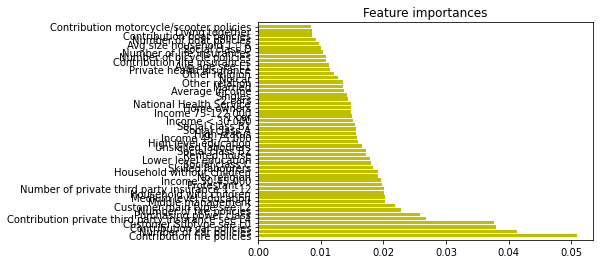

In [ ]:
col_names_sorted, col_feature_scores = get_features_by_importance(clf, True)
show_feature_importance_stats(X_train, col_names_sorted, col_feature_scores, 50)

Importance figures tell you how much predictive power features possess in raw numbers - just multiple them by 100 to get percentage figures. When all summed up it amounts to one (1).

Now let's look at correlation between features to see if we can eliminate some.

In [ ]:
def get_df_by_importance(classifer, df, show_all_features = True):
    """
    INPUT:
    classifier: RandomForestClassifer object
    df: DataFrame to be considered.
    importance_threshold: A cut-off number of importance of columns, above which point to return
    """
    
    feature_ranking_num = df.shape[1] if type(show_all_features) is bool else show_all_features
    
    col_names, _ =  get_features_by_importance(classifer, True)
    return df[col_names[:feature_ranking_num]]    

def show_correlation_among_features(classifier, df, show_all_features = True):
    corr = get_df_by_importance(classifier, df, show_all_features).corr()
    return corr.style.background_gradient(cmap='coolwarm')

In [ ]:
show_correlation_among_features(clf, X_train, 15)

,Contribution fire policies,Number of car policies,Contribution car policies,Customer Subtype see L0,Contribution private third party insurance see L4,Purchasing power class,Number of fire policies,Customer main type see L2,Middle management,Medium level education,Household with children,Number of private third party insurance 1 - 12,Protestant ...,Income 30-45.000,No religion
Contribution fire policies,1.000000,0.108403,0.099442,-0.021949,0.480052,0.100955,0.862355,-0.011458,-0.007888,-0.002113,0.032491,0.482431,0.081060,-0.004770,-0.071861
Number of car policies,0.108403,1.000000,0.915113,-0.019505,0.158626,0.040910,0.031002,-0.016407,0.020029,0.006691,0.029720,0.147227,0.025496,0.022480,-0.017268
Contribution car policies,0.099442,0.915113,1.000000,-0.016514,0.168681,0.031408,0.023711,-0.016152,0.016405,0.003668,0.036515,0.157769,0.021960,0.033540,-0.016796
Customer Subtype see L0,-0.021949,-0.019505,-0.016514,1.000000,-0.047411,-0.572380,-0.023657,0.948039,-0.213948,-0.273145,-0.003109,-0.040417,0.071641,0.144552,-0.005152
Contribution private third party insurance see L4,0.480052,0.158626,0.168681,-0.047411,1.000000,0.013213,0.509897,-0.053357,0.016619,0.015276,-0.035928,0.981406,-0.002301,-0.013590,-0.019243
Purchasing power class,0.100955,0.040910,0.031408,-0.572380,0.013213,1.000000,0.027932,-0.537730,0.136889,0.233601,0.259571,0.004546,0.037614,-0.124822,-0.079053
Number of fire policies,0.862355,0.031002,0.023711,-0.023657,0.509897,0.027932,1.000000,-0.022518,-0.001691,-0.005614,-0.014354,0.518138,0.055041,0.001922,-0.052868
Customer main type see L2,-0.011458,-0.016407,-0.016152,0.948039,-0.053357,-0.537730,-0.022518,1.000000,-0.222455,-0.274875,0.059755,-0.044896,0.083676,0.160354,0.001474
Middle management,-0.007888,0.020029,0.016405,-0.213948,0.016619,0.136889,-0.001691,-0.222455,1.000000,0.395485,-0.029874,0.014679,-0.025266,0.138308,-0.030022
Medium level education,-0.002113,0.006691,0.003668,-0.273145,0.015276,0.233601,-0.005614,-0.274875,0.395485,1.000000,-0.040467,0.007673,-0.018466,-0.000324,-0.040213


We want to see the above as much **UNcorrelated** as possible. Otherwise, the predictive power of one of the pair is rather, hum, feeble and uncertain.

The following pairs deem to be highly correlated:
1. 'Contribution fire policies' and 'Number of fire policies'
2. 'Contribution car policies' and 'Number of car policies',
3. 'Customer Subtype see L0' and 'Customer main type see L2', and
4. 'Contribution private third party insurance see L4' and 'Number of private third party insurance 1 - 12'

Let's take a look at this from another spective via [**Dendrogram**](https://wheatoncollege.edu/wp-content/uploads/2012/08/How-to-Read-a-Dendrogram-Web-Ready.pdf) (Code reference: Jeremy Howard's lesson2-rf_interpretation.ipynb)

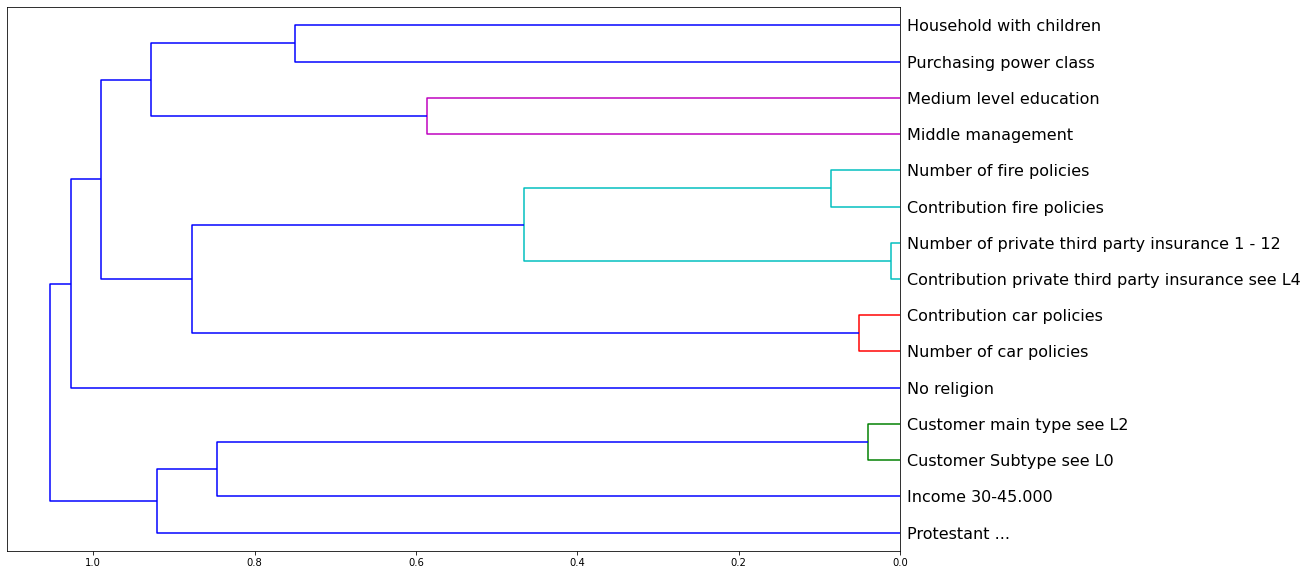

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc

X_train_curtailed_cols_by_importance = get_df_by_importance(clf, X_train, 15)

corr = np.round(scipy.stats.spearmanr(X_train_curtailed_cols_by_importance).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_curtailed_cols_by_importance.columns, orientation='left', leaf_font_size=16)
plt.show()

The above dendrogram confirms those four pairs above, i.e., one or the other is simply redundant.

We will now introduce out-of-bag (oob) score just to give a more randomised spin for better generalisation of model.

In [ ]:
def get_oob(df_x, df_y):
    # Reference: Jeremy Howard's lesson2-rf_interpretation.ipynb
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 42, oob_score=True)
    clf.fit(df_x, df_y)
    return clf.oob_score_

In [ ]:
get_oob(X_train_curtailed_cols_by_importance, y_train)

0.9299978526948679

 This is our baseline to beat: Oob score is lower than that of non-oob by ca. 0.06, which is natural.
 
 We will now remove a redundant feature from each pair and compare their oob scores. 

In [ ]:
dup_col_names = ['Number of fire policies', 'Number of car policies', 'Customer main type see L2', 'Number of private third party insurance 1 - 12']

for col_name in (dup_col_names):
    print(col_name, get_oob(X_train_curtailed_cols_by_importance.drop(col_name, axis=1), y_train))

Number of fire policies 0.9289242001288384
Number of car policies 0.9295683916684561
Customer main type see L2 0.9299978526948679
Number of private third party insurance 1 - 12 0.9310715052608975


Elimination of every single column pretty much results in better oob score. Let's get rid of them all.

In [ ]:
get_oob(X_train_curtailed_cols_by_importance.drop(dup_col_names, axis=1), y_train)

0.9304273137212798

Let's try it out on the full dataset, the entire original training set.

In [ ]:
get_oob(df_features.drop(dup_col_names, axis=1), df_target)

0.9247681209206459

# Hyperparameter Tuning via Gridsearch with cross-validation generator

GridSearch is very handy item to just try out different values in parameters together with cross validation.

In [ ]:
clf2 = RandomForestClassifier(random_state = 42)
print ("DEFAULT Parameters in use:\n")
clf2.get_params()

DEFAULT Parameters in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap}

print(grid)

{'n_estimators': [10, 17, 24, 32, 39, 46, 54, 61, 68, 76, 83, 91, 98, 105, 113, 120, 127, 135, 142, 150], 'max_features': ['auto', 'sqrt'], 'bootstrap': [True, False]}


In [ ]:
clf2 = RandomForestClassifier()

# Training set and test set have 4,657 and 4,000 samples respectively
# Use default 5-fold (cv = 5) as in sk-learn v0.22
clf_grid = GridSearchCV(estimator = clf2, param_grid = grid, cv = 5, verbose=2, n_jobs = -1)
clf_grid.fit(df_features, df_target)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
clf_grid.best_params_

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 24}

In [ ]:
clf_final = RandomForestClassifier(n_estimators = 24, max_features = 'sqrt', random_state = 42)
clf_final.fit(df_features, df_target) 
build_confusion_matrix(clf_final, X_test, y_test)

Predicted Classes     0   1
Actual Classes             
0                  3714  48
1                   222  16

Correct: 3,730, Incorrect: 270, Total: 4,000 => Accuracy: 93.2500%


Marginally better - by 0.25%!

# After-thoughts...

Hum, you might have a hunch that one SINGLE tree can predict better after all? Be my guest!

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(max_features = 'sqrt', random_state = 42)
clf_dt.fit(df_features, df_target) 
build_confusion_matrix(clf_dt, X_test, y_test)

Predicted Classes     0    1
Actual Classes              
0                  3546  216
1                   208   30

Correct: 3,576, Incorrect: 424, Total: 4,000 => Accuracy: 89.4000%


Did I prove you wrong then? Yeah surely. Let's try a couple of other ensembling methods, namely AdaBoost and GradientBoosting.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_abc = AdaBoostClassifier(n_estimators=24, random_state = 42)
clf_abc.fit(df_features, df_target) 
build_confusion_matrix(clf_abc, X_test, y_test)

Predicted Classes     0  1
Actual Classes            
0                  3758  4
1                   236  2

Correct: 3,760, Incorrect: 240, Total: 4,000 => Accuracy: 94.0000%


By 0.75% better than RandomForest

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbc = AdaBoostClassifier(n_estimators=24, random_state = 42)
clf_gbc.fit(df_features, df_target) 
build_confusion_matrix(clf_gbc, X_test, y_test)

Predicted Classes     0  1
Actual Classes            
0                  3758  4
1                   236  2

Correct: 3,760, Incorrect: 240, Total: 4,000 => Accuracy: 94.0000%
